## The purpose of this homework is to implement Canny Edge Detector

In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook

from skimage.io import imread
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm

In [2]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from scipy import ndimage
import cv2

### As you know from theory, Canny Edge Detection algorithm is composed of 4 steps: 
- Bluring the image to suppress the noise
- Calculation of the gradient and the magnitude of the image-gradient
- Non-maximum suppression
- Hystersis thresholding

#### At first let's read and visualize an image.

In [3]:
img = imread('tree.jpg')/255.
img = resize(img, (240, 320), preserve_range=True)
img = rgb2gray(img)

<IPython.core.display.Javascript object>


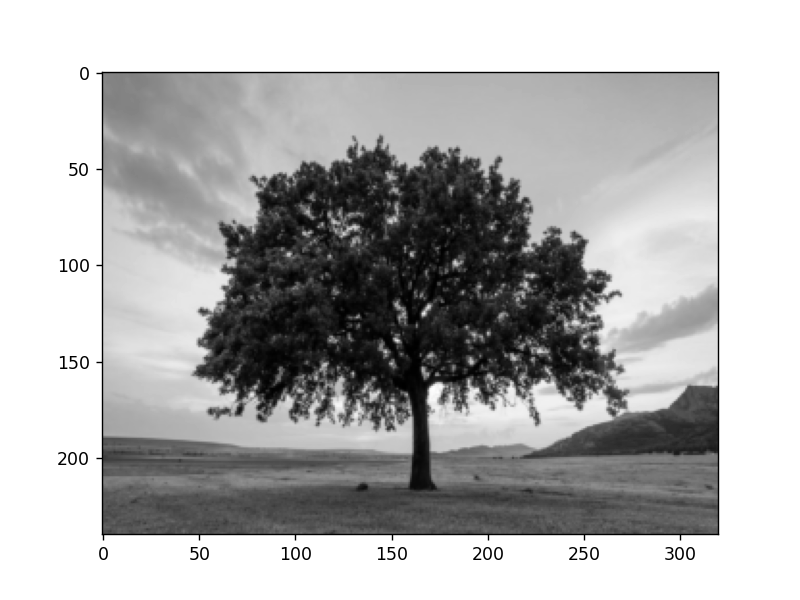

In [5]:
plt.imshow(img, cmap = 'gray')

In order to suppress the noise in the image, we apply bluring.

### Step 1: Gaussian blur

In [16]:
def display_image(img):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

<IPython.core.display.Javascript object>


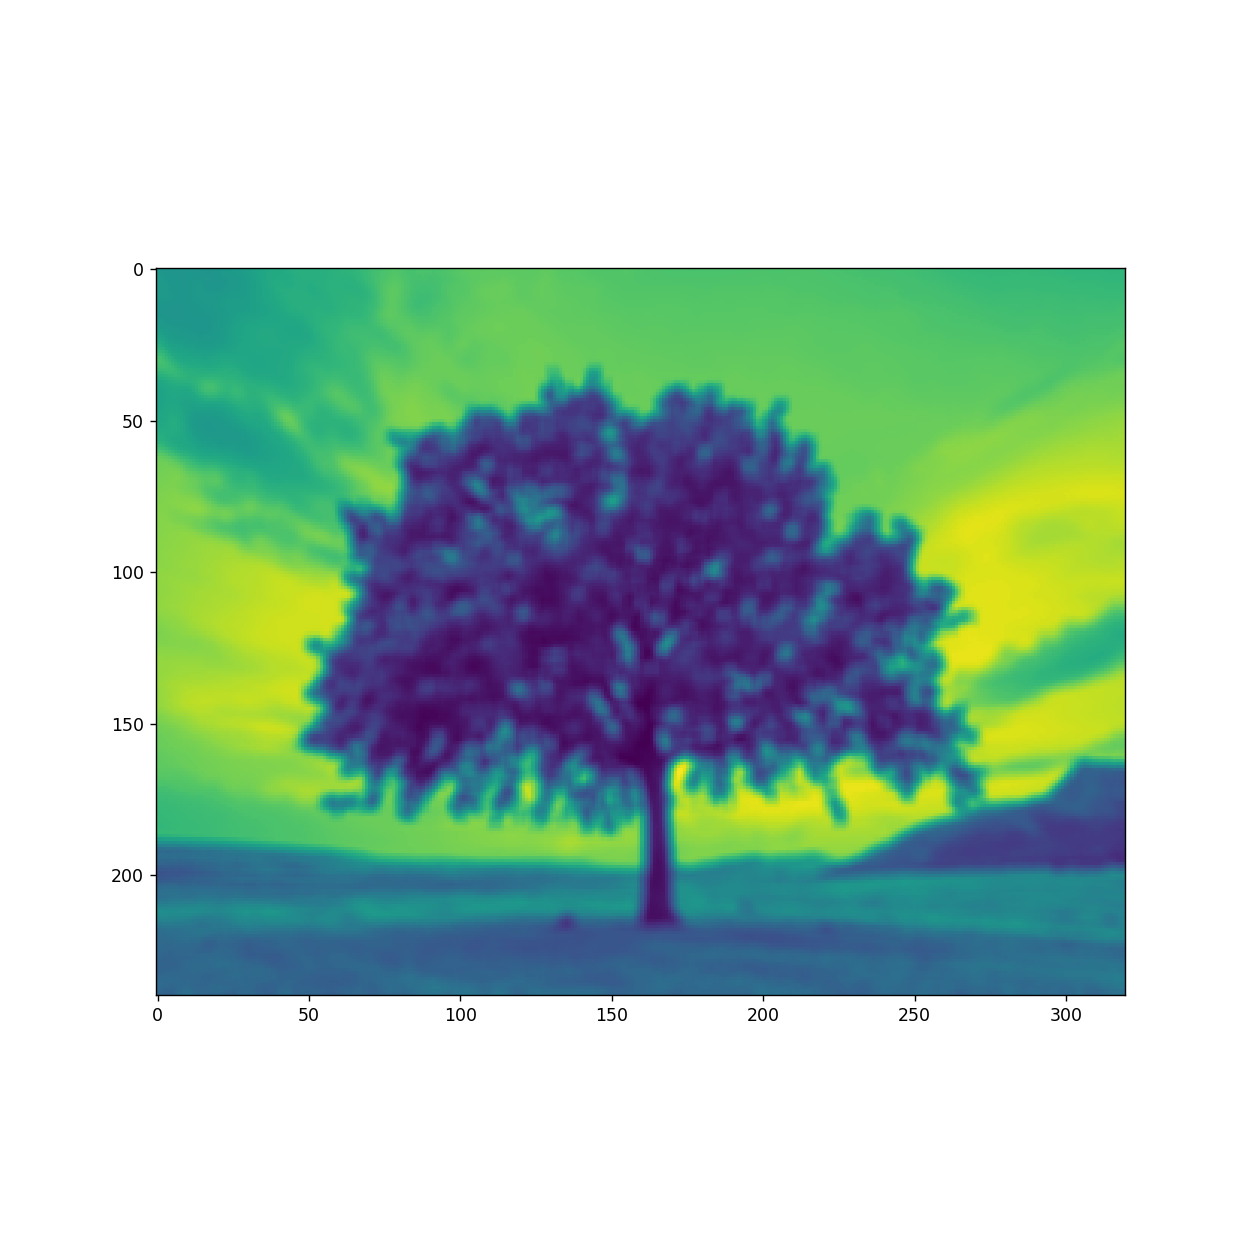

In [18]:
smooth_img = cv2.GaussianBlur(img, (5,5), 10)
display_image(smooth_img)

### Step 2: Gradient Calculation

In [26]:
# compute gradients along the X and Y axis, respectively
G_x = cv2.Sobel(smooth_img, cv2.CV_64F, 1, 0, ksize = 5) 
G_y = cv2.Sobel(smooth_img, cv2.CV_64F, 0, 1, ksize = 5)
M = np.sqrt(G_x * G_x + G_y * G_y)
M = M/M.max()

<IPython.core.display.Javascript object>


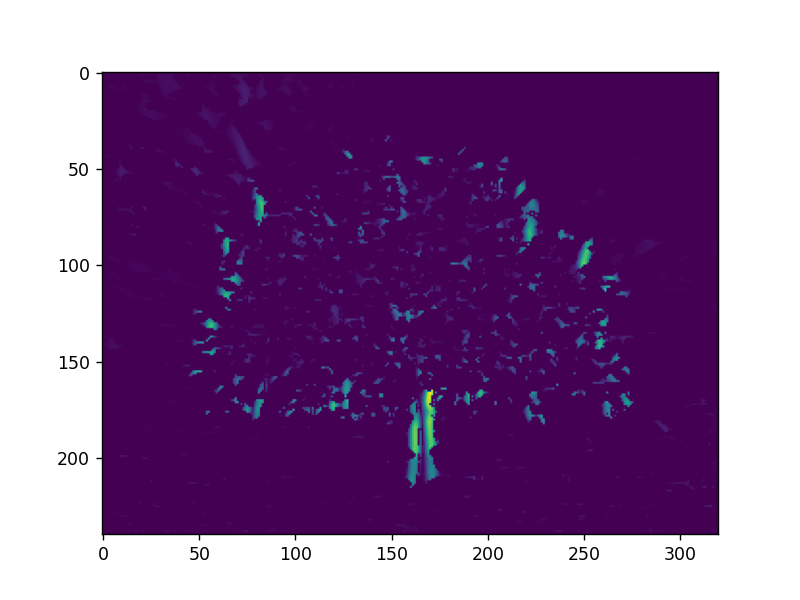

In [27]:
plt.imshow(M)
#G_x.shape

### Step 3: Non-Maximum Suppression

#### Note !!! for implementation of non-maximum suppression you can follow the following steps, but your own implementation is also applicable.

Defining four directions

In [30]:
d_x = (1, 1/np.sqrt(2), 0, 1/np.sqrt(2))
d_y = (0, 1/np.sqrt(2), 1, -1/np.sqrt(2))
D = np.array([[d_x[i], d_y[i]] for i in range(4)])


array([[ 1.        ,  0.        ],
       [ 0.70710678,  0.70710678],
       [ 0.        ,  1.        ],
       [ 0.70710678, -0.70710678]])

In [31]:
d_x

(1, 0.7071067811865475, 0, 0.7071067811865475)

In [32]:
d_y

(0, 0.7071067811865475, 1, -0.7071067811865475)

In [86]:
theta = np.arctan2(G_y, G_x) * 180 / np.pi # element wise arctan , returns angles in radians.
## QUESTION ? Maybe I should take theta in radians?
# theta = np.arctan2(G_y, G_x) # in radians

0.0

In [78]:
theta[theta<0] += 180
theta

array([[  0.        , 180.        , 180.        , ...,   0.        ,
          0.        , 180.        ],
       [ 90.        , 131.7463899 , 153.93346428, ...,  57.61847873,
         64.86738999,  90.        ],
       [ 90.        , 119.33305071, 141.10741281, ...,  76.72614056,
         80.60125615,  90.        ],
       ...,
       [ 90.        ,  65.87346622,  63.09435088, ..., 102.08696522,
         93.45359918,  90.        ],
       [ 90.        ,  60.29886544,  58.21896134, ..., 101.77565862,
         91.22087248,  90.        ],
       [180.        , 180.        , 180.        , ...,   0.        ,
        180.        ,   0.        ]])

In [80]:
# TODO Obtain a matrix of shape (img.shape[0], img.shape[1]), 
# for which A[i,j] is the number of the closest direction from D in the point (i,j). 
# For example, if the direction D[1,:] is the closest to the gradient of the image in the point (i,j), 
# i.e. G[i,j,:], then A[i,j] = 1.
A = np.zeros((img.shape[0], img.shape[1]))
for i in range(0, img.shape[0]):
    for j in range(0, img.shape[1]):
        if(theta[i,j] >= 0 and theta[i,j] <= 20) or (theta[i,j] >= 160 and theta[i,j] <= 180) :
            A[i,j] = 0 # 0 angle
        elif(theta[i,j] > 20 and theta[i,j] <= 60):
            A[i,j] = 1 # 45 angle
        elif(theta[i,j] > 60 and theta[i,j] <= 110):
            A[i,j] = 2 # 90 angle 
        elif(theta[i,j] > 110 and theta[i,j] <= 155):
            A[i,j] = 3 # 135 angle    

In [81]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 3., 3., ..., 1., 2., 2.],
       [2., 3., 3., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 1., ..., 2., 2., 2.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
res = np.zeros((img.shape[0], img.shape[1]))
M_pad = np.zeros((img.shape[0]+2, img.shape[1]+2))
M_pad[1:-1,1:-1] = M.copy() # M is Gradient
for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
        if A[i,j] == 0:
            M_p = A[i, j-1]
            M_n = A[i, j+1]
        elif A[i,j] == 3:
            M_p = A[i-1, j-1]
            M_n = A[i+1, j+1]
        elif A[i,j] == 2:
            M_p = A[i+1, j]
            M_n = A[i-1, j]
        elif A[i,j] == 1:
            M_p = A[i+1, j-1]
            M_n = A[i-1, j+1]
        
        if M_pad[i,j] >= M_p and M_pad[i,j] >= M_n:
            res[i,j] = M_pad[i,j]
M_pad

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.86193244e-03, ...,
        2.13752807e-03, 3.85082278e-17, 0.00000000e+00],
       [0.00000000e+00, 5.98301718e-03, 7.68091831e-03, ...,
        4.51910184e-03, 3.87306708e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 3.31221459e-02, 3.86556123e-02, ...,
        4.54869529e-02, 4.70581931e-02, 0.00000000e+00],
       [0.00000000e+00, 1.92541139e-17, 1.96078809e-02, ...,
        6.12392466e-04, 3.85082278e-17, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

<IPython.core.display.Javascript object>


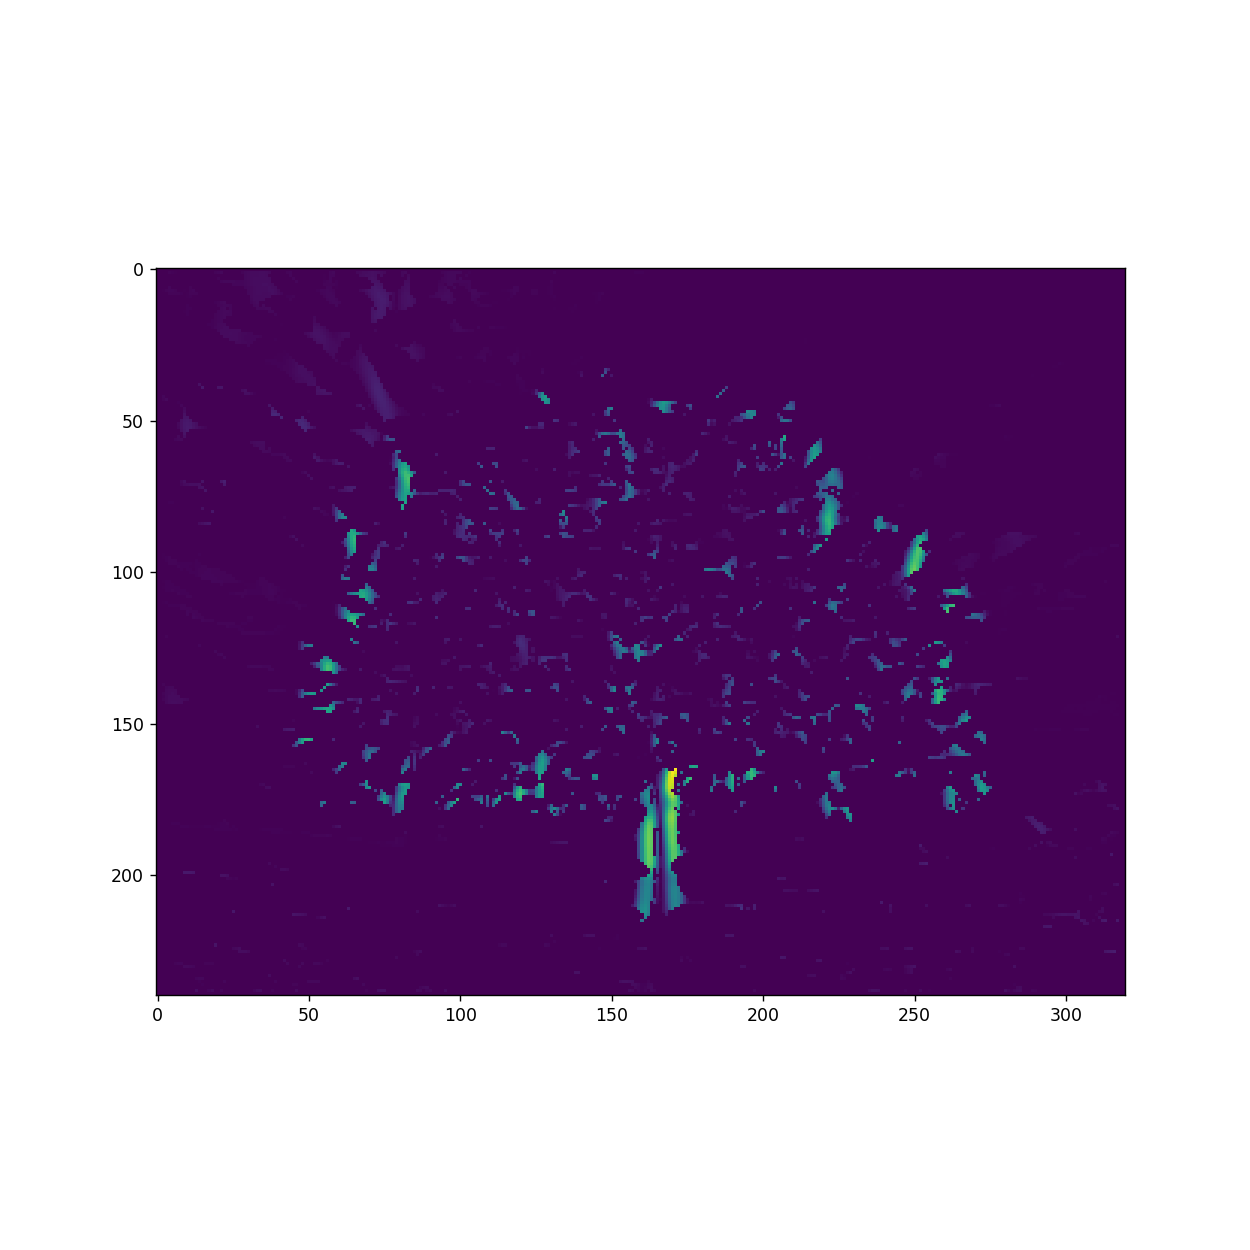

In [97]:
display_image(res)

<IPython.core.display.Javascript object>


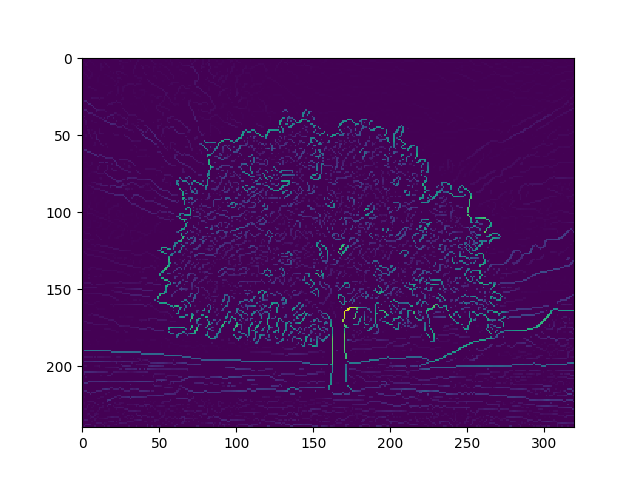

In [246]:
plt.imshow(res)

### Step 4: Hystersis Thresholding

In [104]:
# The hysteresis consists of transforming weak pixels into strong ones, 
# if and only if at least one of the pixels around the one being processed is a strong one.

def hyst(img, t_h, t_l):    
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == t_l):
                if((img[i, j-1]   == t_h)   or (img[i, j + 1] == t_h) or 
                   (img[i+1, j]   == t_h)   or (img[i-1, j]   == t_h) or
                   (img[i+1, j-1] == t_h)   or (img[i-1, j+1] == t_h) or
                   (img[i-1, j-1] == t_h)   or (img[i+1, j+1] == t_h)):
                    img[i, j] = t_h
                else:
                    img[i, j] = 0
    return img 

In [109]:
can_res = hyst(res, 0.2, 0.05)

<IPython.core.display.Javascript object>


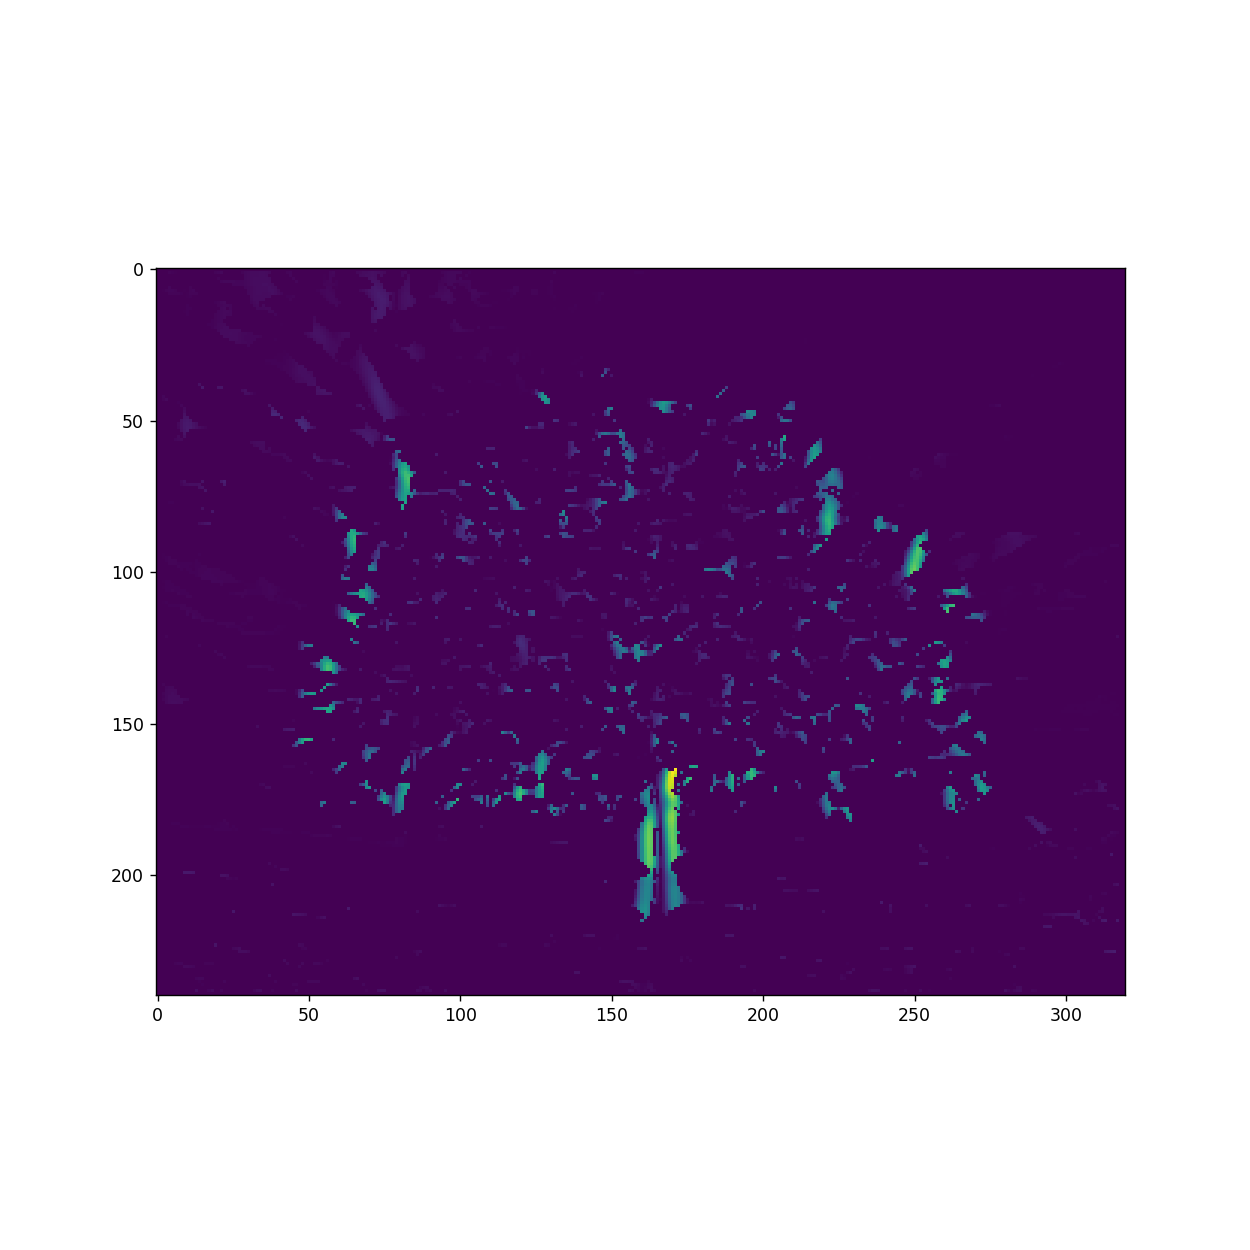

In [110]:
display_image(can_res)

<IPython.core.display.Javascript object>


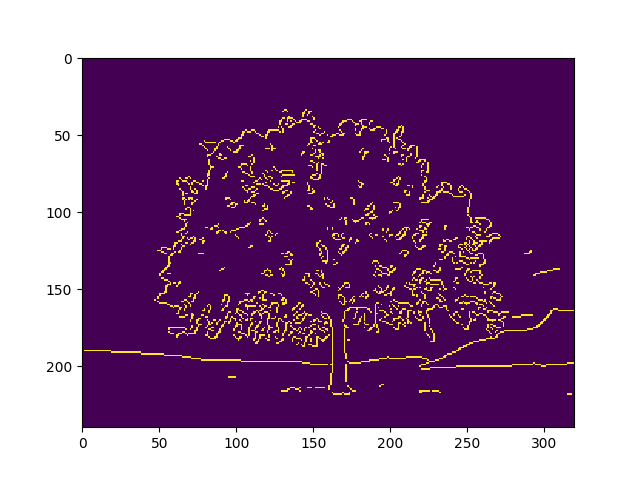

In [250]:
plt.imshow(can_res)